# **Costa Rica - Seizure and Homicide Data Analysis**
#### InSight Crime - MAD Unit 
June, 2025


---------------------



### Introduction

Data:

1. **Intentional Homicides in Costa Rica (2010–2024)**
     
	Formatted data available [here](https://docs.google.com/spreadsheets/d/1-XG8sMyPwBXa6bdBCqqEPm2SrcHpKKn3YAHaBdyR-Lg/edit?gid=0#gid=0)  
	Source: [Intentional Homicides CR](https://drive.google.com/file/d/1cUswepSw-r3HLU6Be3duvjsRw329MoKg/view?ts=6841b341)
	
	Notes: There are some discrepancies in the population figures by year compared to the [INEC](https://services.inec.go.cr/proyeccionpoblacion/frmproyec.aspx) (at both national and provincial levels), but they do not affect the homicide rates per 100,000 inhabitants as reported in the source.

2. **Seizure data (2018-2024)**
   
	Source: [Control_de_la_Oferta_ODS_SW1 (Sheet "8")](https://docs.google.com/spreadsheets/d/1EhZ7hpFBpIFc375ByzMu1AIQrNnvw2FxIvXlxV5KE1E/edit?gid=661345260#gid=661345260) 

3. **Merged dataset**

	Available [here](https://github.com/FelipeVillota/costa-rica-presentation/tree/main/data/merged) 
	
	Notes: Dataframes were combined considering geographic disaggregation and time. Leaving us with country-level observations/indicators, by year, from 2018-2014. This is the starting point for the analysis


### Project Setup

#### Version Control

The project is created within a single GitHub repository ([FelipeVillota/costa-rica-presentation](https://github.com/FelipeVillota/costa-rica-presentation)). I keep the repository `private` with the possibility to give collaborator-access to the online repo at any time. 

#### Reproducible Environment

In [92]:
# IMPORTANT

# In the Terminal, run the following commands to set up a virtual environment called `venv-cr`:
# python -m venv venv-cr

# To activate environment, run (the first is an optional, temporary auth) :
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass
# venv-cr\Scripts\activate

# Then select respective kernel 

# Update list master list
# pip freeze > requirements.txt

In [93]:
# Checking venv-db-watch works --> accept to install ipykernel package to connect to kernel if asked
import sys
print(sys.executable)

c:\Users\USER\Desktop\ic\costa-rica\costa-rica-presentation\venv-cr\Scripts\python.exe


#### Loading Libraries

In [94]:
# Install the required packages in the virtual environment:
# pip install --upgrade pip
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas
# pip install gspread gspread-formatting seaborn matplotlib missingno    

In [95]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from io import BytesIO
from openpyxl import load_workbook


# pip freeze > requirements.txt

### Loading Data

In [96]:
# Both datasets are in the repository, so we can use raw GitHub URLs to access them directly.
# Use raw GitHub URLs
url_homicides = "https://github.com/FelipeVillota/costa-rica-presentation/raw/main/data/raw/homicides-2010-2024.xlsx" # Multiple sheets 
url_seizures = "https://github.com/FelipeVillota/costa-rica-presentation/raw/main/data/raw/seizures-2019-2024.xlsx" # This is already the sheet we want

# Get file content
response1 = requests.get(url_homicides)
response2 = requests.get(url_seizures)

In [97]:
# Seizures data is already in a single sheet, so we can load it directly
seizures_sheets = pd.read_excel(BytesIO(response2.content), engine='openpyxl', sheet_name=None)
seizures_df = seizures_sheets['8']  


In [98]:
# Homicide data is in multiple sheets, we want to load only the second sheet called "tasa-país"
homicides_sheets = pd.read_excel(BytesIO(response1.content), engine='openpyxl', sheet_name=None)
homicides_df = homicides_sheets['tasa-país']

In [99]:
# All sheets
homicides_sheets

{'histórico-mensual':            país         mes   año  homicidios_país_mes  \
 0    Costa Rica       enero  2010                   44   
 1    Costa Rica     febrero  2010                   45   
 2    Costa Rica       marzo  2010                   47   
 3    Costa Rica       abril  2010                   42   
 4    Costa Rica        mayo  2010                   39   
 ..          ...         ...   ...                  ...   
 175  Costa Rica      agosto  2024                   75   
 176  Costa Rica  septiembre  2024                   69   
 177  Costa Rica     octubre  2024                   73   
 178  Costa Rica   noviembre  2024                   73   
 179  Costa Rica   diciembre  2024                   80   
 
      homicidios_país_acumulado_mes  homicidios_país_año  
 0                              756                  527  
 1                              690                  527  
 2                              699                  527  
 3                              6

In [100]:
print(seizures_df.head())

         País Provincia    Cantón     Distrito   Cocaína Eventos  \
0  Costa Rica  Alajuela  Alajuela     Alajuela             161.0   
1  Costa Rica  Alajuela  Alajuela     San José             144.0   
2  Costa Rica  Alajuela  Alajuela     Carrizal               9.0   
3  Costa Rica  Alajuela  Alajuela  San Antonio              34.0   
4  Costa Rica  Alajuela  Alajuela      Guácima              51.0   

   Cocaína (kg)  Crack Eventos  Crack (piedras)  Marihuana Eventos  \
0       0.05825          370.0      6644.400000              769.0   
1       0.70250          289.0     10406.666667              478.0   
2       0.00625            9.0       204.000000               21.0   
3       0.32975           60.0       913.333333              449.0   
4       0.93440          155.0      5812.333333              450.0   

   Marihuana (kg)     Año  
0        14.33302  2019.0  
1         1.45790  2019.0  
2         0.03950  2019.0  
3         1.06203  2019.0  
4         2.08663  2019.0  


In [101]:
# Now we want to merge the two datasets on the year column.
 
# But first, we need to ensure that the year columns in both datasets are in the same format.
homicides_df['año'] = pd.to_datetime(homicides_df['año'], errors='coerce', format='%Y').dt.year
seizures_df['Año'] = pd.to_datetime(seizures_df['Año'], format='%Y').dt.year

# And change the column name to match
homicides_df.rename(columns={'año': 'year'}, inplace=True)
seizures_df.rename(columns={'Año': 'year'}, inplace=True)


In [102]:
# seizure data is showing values like 2019.0, so we need to convert it to int
seizures_df['year'] = seizures_df['year'].astype('Int64')

In [103]:
# Now we can merge the two datasets on the 'year' column.
merged_df = pd.merge(homicides_df, seizures_df, on='year', how='outer')

In [104]:
# To keep it simple, we keep only record from 2018 to 2024
merged_df = merged_df[merged_df['year'] >= 2018]

In [105]:
merged_df.head()
print(merged_df.info())

# Now we can save the merged dataset to a new Excel file.
def save_merged_df(merged_df, output_path='data/merged/merged_data-2018-2024.xlsx'):
    merged_df.to_excel(output_path, index=False)
save_merged_df(merged_df)

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 8 to 3405
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   país                 3398 non-null   object 
 1   year                 3398 non-null   Int64  
 2   homicidios_país_año  3398 non-null   float64
 3   habitantes_país      3398 non-null   float64
 4   tasa_100mil_país     3398 non-null   float64
 5   País                 3398 non-null   object 
 6   Provincia            3398 non-null   object 
 7   Cantón               3398 non-null   object 
 8   Distrito             3398 non-null   object 
 9    Cocaína Eventos     3398 non-null   float64
 10  Cocaína (kg)         3398 non-null   float64
 11  Crack Eventos        3398 non-null   float64
 12  Crack (piedras)      3398 non-null   float64
 13  Marihuana Eventos    3398 non-null   float64
 14  Marihuana (kg)       3398 non-null   float64
dtypes: Int64(1), float64(9), object(5)
memory u

### Execution

#### Pre-processing

In [106]:
# Format Missing/Invalid Values

merged_df = merged_df.replace('', pd.NA)  # Convert empty strings to NA
merged_df = merged_df.replace(r'^\s*$', pd.NA, regex=True)  # Convert whitespace to NA
print("✓ Converted empty strings/whitespace to NA values")

✓ Converted empty strings/whitespace to NA values


In [ ]:
# Lowercase column names and put _ between words
merged_df.columns = [col.lower() for col in merged_df.columns]

# Remove spaces left and right
merged_df.columns = merged_df.columns.str.strip()

#  put _ between words
merged_df.columns = [re.sub(r'\s+', '_', col.lower()) for col in merged_df.columns]


<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 8 to 3405
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   país                 3398 non-null   object 
 1   year                 3398 non-null   Int64  
 2   homicidios_país_año  3398 non-null   float64
 3   habitantes_país      3398 non-null   float64
 4   tasa_100mil_país     3398 non-null   float64
 5   país                 3398 non-null   object 
 6   provincia            3398 non-null   object 
 7   cantón               3398 non-null   object 
 8   distrito             3398 non-null   object 
 9   cocaína_eventos      3398 non-null   float64
 10  cocaína_(kg)         3398 non-null   float64
 11  crack_eventos        3398 non-null   float64
 12  crack_(piedras)      3398 non-null   float64
 13  marihuana_eventos    3398 non-null   float64
 14  marihuana_(kg)       3398 non-null   float64
dtypes: Int64(1), float64(9), object(5)
memory u

In [108]:
# Drop the second (duplicated) 'país' column
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Arrange columns in a more logical order 

column_order = [
    'país', 'provincia', 'cantón', 'distrito', 'year',
    'habitantes_país', 'homicidios_país_año', 'tasa_100mil_país',
    'cocaína_eventos', 'cocaína_(kg)',
    'crack_eventos', 'crack_(piedras)',
    'marihuana_eventos', 'marihuana_(kg)'
]
merged_df = merged_df[column_order]

### Data Analysis

##### EDA - Summary Stats

In [109]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

def get_dataframe_summary(merged_df, output_path='data/results/merged_summary-2018-2024.xlsx'):
    # --- General DataFrame Info ---
    general_info = {
        "Shape": f"{merged_df.shape[0]} rows × {merged_df.shape[1]} cols",
        "Memory Usage": f"{merged_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB",
        "Columns with NA": f"{merged_df.isna().any().sum()} / {len(merged_df.columns)}",
        "Duplicate Rows": f"{merged_df.duplicated().sum()} ({(merged_df.duplicated().mean() * 100):.1f}%)",
        "Numeric Columns": f"{merged_df.select_dtypes(include='number').shape[1]}",
        "Categorical Columns": f"{merged_df.select_dtypes(include=['object', 'category']).shape[1]}",
        "Datetime Columns": f"{merged_df.select_dtypes(include='datetime').shape[1]}"
    }

    # --- Column-Level Stats ---
    column_stats = pd.DataFrame({
        'Variable': merged_df.columns,
        'Dtype': merged_df.dtypes.values,
        'Unique_Count': merged_df.nunique().values,
        'NA_Count': merged_df.isna().sum().values,
        'NA_Percentage': (merged_df.isna().mean() * 100).round(1).values,
        'Duplicate_Count': merged_df.apply(lambda col: col.duplicated(keep=False).sum()).values,
        'Duplicate_Percentage': (merged_df.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(1).values,
        'Unique_Values': merged_df.apply(lambda x: x.drop_duplicates().tolist()).values
    }).sort_values('Unique_Count', ascending=False)


    # Format percentages
    column_stats['NA_Percentage'] = column_stats['NA_Percentage'].astype(str) + '%'
    column_stats['Duplicate_Percentage'] = column_stats['Duplicate_Percentage'].astype(str) + '%'
    
# --- Save to Excel ---
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Save general info to first sheet
        pd.DataFrame.from_dict(general_info, orient='index', columns=['Value'])\
            .to_excel(writer, sheet_name='General Info')
        
        # Save column stats to second sheet
        column_stats.to_excel(writer, sheet_name='Column Stats', index=False)
        
        # Auto-adjust column widths
        for sheet_name in writer.sheets:
            sheet = writer.sheets[sheet_name]
            for column in sheet.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(str(cell.value))
                    except:
                        pass
                adjusted_width = (max_length + 2)
                sheet.column_dimensions[column_letter].width = adjusted_width

    print(f"✓ Summary saved to {output_path}")
    return general_info, column_stats

# Run the summary
general_info, column_stats = get_dataframe_summary(merged_df)

# Print General Info
print("=== GENERAL DATAFRAME INFO ===")
for key, value in general_info.items():
    print(f"{key}: {value}")

# Display Column Stats (including dropdown options)
print("\n=== COLUMN-LEVEL STATISTICS ===")
display(column_stats)


✓ Summary saved to data/results/merged_summary-2018-2024.xlsx
=== GENERAL DATAFRAME INFO ===
Shape: 3398 rows × 14 cols
Memory Usage: 1.08 MB
Columns with NA: 0 / 14
Duplicate Rows: 0 (0.0%)
Numeric Columns: 10
Categorical Columns: 4
Datetime Columns: 0

=== COLUMN-LEVEL STATISTICS ===


,Variable,Dtype,Unique_Count,NA_Count,NA_Percentage,Duplicate_Count,Duplicate_Percentage,Unique_Values
13,marihuana_(kg),float64,2651,0,0.0%,976,28.7%,"[3.79137949254408, 8.64565, 0.13497, 1.28543, ..."
11,crack_(piedras),float64,1511,0,0.0%,2217,65.2%,"[9051.13333333333, 17697.2222222222, 87.0, 780..."
9,cocaína_(kg),float64,1287,0,0.0%,2316,68.2%,"[0.1469, 0.23475, 0.0015, 0.1175, 0.03345, 0.8..."
12,marihuana_eventos,float64,632,0,0.0%,3120,91.8%,"[842.0, 249.0, 55.0, 336.0, 219.0, 27.0, 77.0,..."
3,distrito,object,397,0,0.0%,3395,99.9%,"[Alajuela, San José, Carrizal, San Antonio, Gu..."
10,crack_eventos,float64,305,0,0.0%,3256,95.8%,"[350.0, 164.0, 15.0, 66.0, 55.0, 6.0, 7.0, 146..."
8,cocaína_eventos,float64,211,0,0.0%,3308,97.4%,"[100.0, 74.0, 3.0, 39.0, 21.0, 5.0, 54.0, 78.0..."
2,cantón,object,93,0,0.0%,3396,99.9%,"[Alajuela, San Ramón, Grecia, San Mateo, Atena..."
1,provincia,object,12,0,0.0%,3397,100.0%,"[Alajuela, Cartago, Guanacaste, Heredia, Limón..."
4,year,Int64,7,0,0.0%,3398,100.0%,"[2018, 2019, 2020, 2021, 2022, 2023, 2024]"


In [110]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 8 to 3405
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   país                 3398 non-null   object 
 1   provincia            3398 non-null   object 
 2   cantón               3398 non-null   object 
 3   distrito             3398 non-null   object 
 4   year                 3398 non-null   Int64  
 5   habitantes_país      3398 non-null   float64
 6   homicidios_país_año  3398 non-null   float64
 7   tasa_100mil_país     3398 non-null   float64
 8   cocaína_eventos      3398 non-null   float64
 9   cocaína_(kg)         3398 non-null   float64
 10  crack_eventos        3398 non-null   float64
 11  crack_(piedras)      3398 non-null   float64
 12  marihuana_eventos    3398 non-null   float64
 13  marihuana_(kg)       3398 non-null   float64
dtypes: Int64(1), float64(9), object(4)
memory usage: 401.5+ KB
None


#### Overview

In [ ]:
# Overview
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== DRUG SEIZURES & HOMICIDES ANALYSIS ===")
print("📊 Dataset Overview:")
print(f"Shape: {merged_df.shape}")
print(f"Time period: {merged_df['year'].min()} - {merged_df['year'].max()}")
print(f"Countries: {merged_df['país'].nunique()}")
print(f"Provinces: {merged_df['provincia'].nunique()}")

# Basic statistics
print("\n📈 Key Statistics:")
print(f"Total homicides (sum): {merged_df['homicidios_país_año'].sum():,.0f}")
print(f"Average homicide rate per 100k: {merged_df['tasa_100mil_país'].mean():.2f}")
print(f"Total cocaine seized (kg): {merged_df['cocaína_(kg)'].sum():,.0f}")
print(f"Total marijuana seized (kg): {merged_df['marihuana_(kg)'].sum():,.0f}")

# Missing data check
print("\n🔍 Data Quality:")
missing_data = merged_df.isnull().sum()
print("Missing values per column:")
for col, missing in missing_data.items():
    if missing > 0:
        print(f"  {col}: {missing} ({missing/len(merged_df)*100:.1f}%)")

# Geographic distribution
print("\n🌍 Geographic Distribution:")
country_summary = merged_df.groupby('país').agg({
    'homicidios_país_año': 'mean',
    'tasa_100mil_país': 'mean',
    'cocaína_(kg)': 'sum',
    'marihuana_(kg)': 'sum',
    'crack_(piedras)': 'sum'
}).round(2)
print(country_summary)

=== DRUG SEIZURES & HOMICIDES ANALYSIS ===
📊 Dataset Overview:
Shape: (3398, 14)
Time period: 2018 - 2024
Countries: 1
Provinces: 12

📈 Key Statistics:
Total homicides (sum): 2,304,873
Average homicide rate per 100k: 13.12
Total cocaine seized (kg): 222,227
Total marijuana seized (kg): 119,266

🔍 Data Quality:
Missing values per column:

🌍 Geographic Distribution:
            homicidios_país_año  tasa_100mil_país  cocaína_(kg)  \
país                                                              
Costa Rica                678.3             13.12      222227.4   

            marihuana_(kg)  crack_(piedras)  
país                                         
Costa Rica       119266.42       2472717.81  


=== TEMPORAL TRENDS ANALYSIS ===


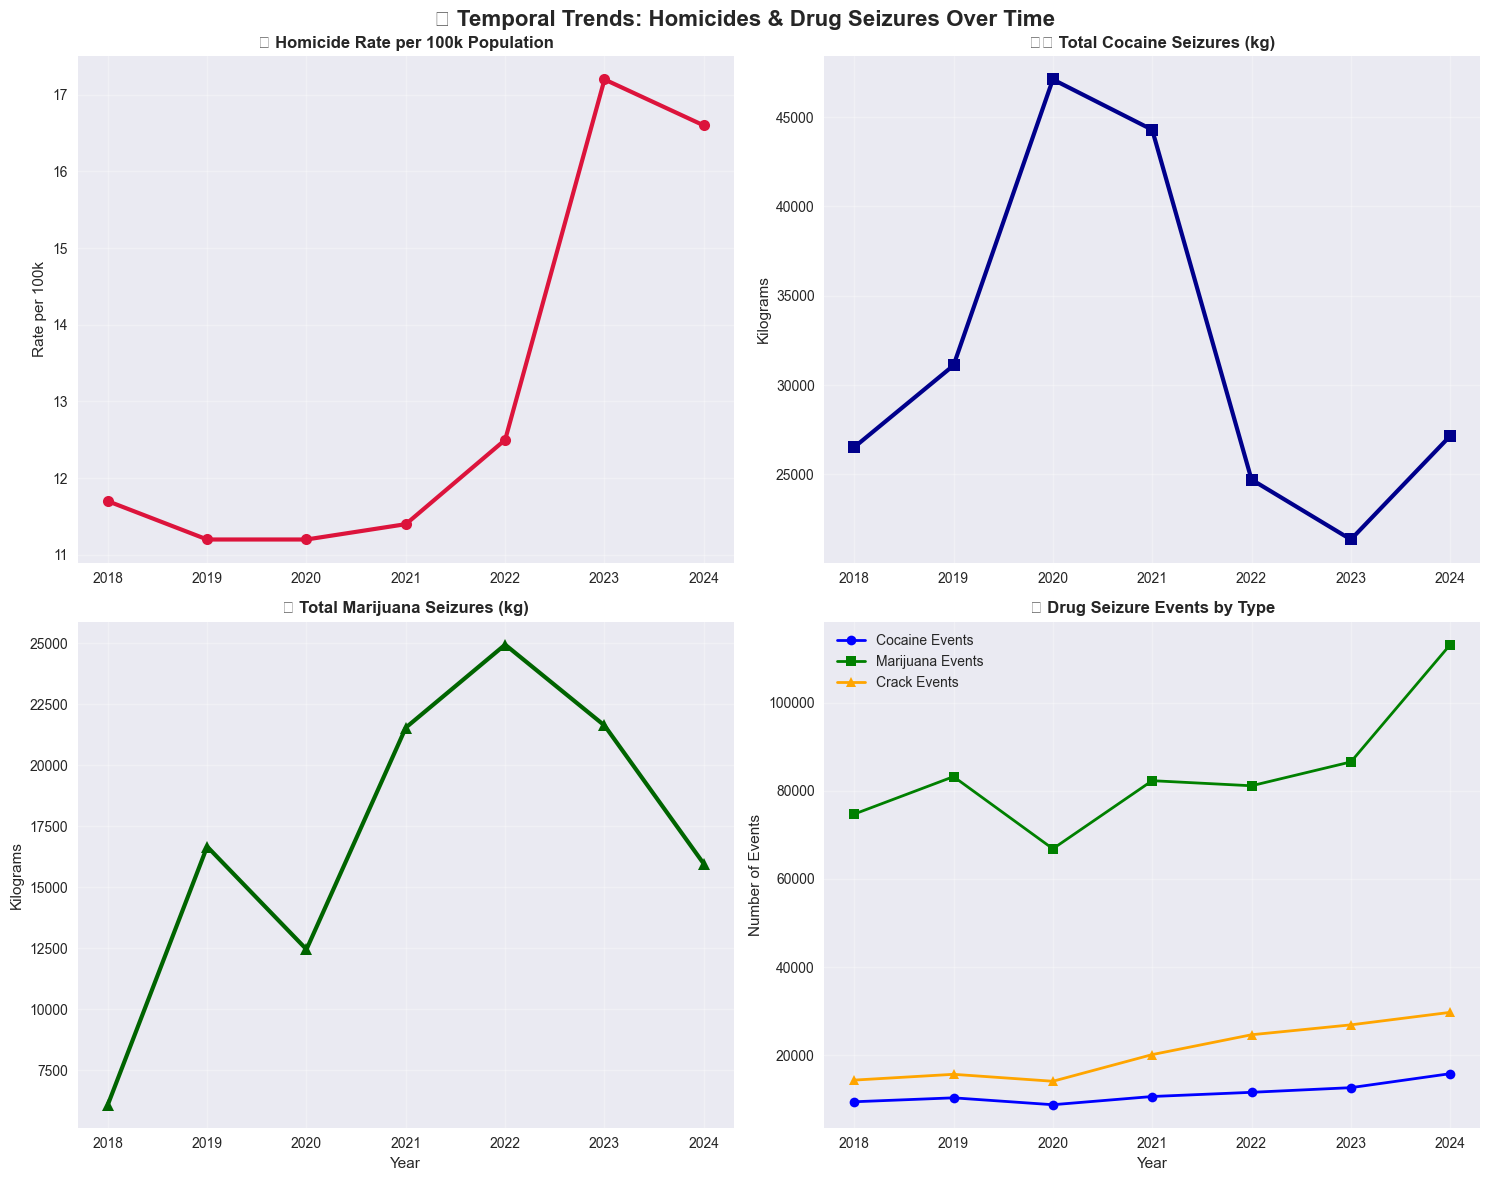


📊 Year-over-Year Changes:
tasa_100mil_país: +6.9% average annual change
cocaína_(kg): +5.4% average annual change
marihuana_(kg): +32.9% average annual change

🏔️ Peak Years:
Highest homicide rate: 2023 (17.2 per 100k)
Largest cocaine seizure: 2020 (47,106 kg)
Largest marijuana seizure: 2022 (24,937 kg)


In [ ]:
# Time Series Analysis
print("=== TEMPORAL TRENDS ANALYSIS ===")

# Create time series aggregations
yearly_trends = merged_df.groupby('year').agg({
    'homicidios_país_año': 'mean',
    'tasa_100mil_país': 'mean',
    'cocaína_(kg)': 'sum',
    'marihuana_(kg)': 'sum',
    'cocaína_eventos': 'sum',
    'marihuana_eventos': 'sum',
    'crack_eventos': 'sum',
    'crack_(piedras)': 'sum'
}).reset_index()

# Create comprehensive time series plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📈 Temporal Trends: Homicides & Drug Seizures Over Time', fontsize=16, fontweight='bold')

# Homicide rate trends
axes[0,0].plot(yearly_trends['year'], yearly_trends['tasa_100mil_país'], 
               marker='o', linewidth=3, markersize=8, color='crimson')
axes[0,0].set_title('🔴 Homicide Rate per 100k Population', fontweight='bold')
axes[0,0].set_ylabel('Rate per 100k')
axes[0,0].grid(True, alpha=0.3)

# Cocaine seizures
axes[0,1].plot(yearly_trends['year'], yearly_trends['cocaína_(kg)'], 
               marker='s', linewidth=3, markersize=8, color='darkblue')
axes[0,1].set_title('❄️ Total Cocaine Seizures (kg)', fontweight='bold')
axes[0,1].set_ylabel('Kilograms')
axes[0,1].grid(True, alpha=0.3)

# Marijuana seizures
axes[1,0].plot(yearly_trends['year'], yearly_trends['marihuana_(kg)'], 
               marker='^', linewidth=3, markersize=8, color='darkgreen')
axes[1,0].set_title('🌿 Total Marijuana Seizures (kg)', fontweight='bold')
axes[1,0].set_ylabel('Kilograms')
axes[1,0].set_xlabel('Year')
axes[1,0].grid(True, alpha=0.3)

# Drug events comparison
axes[1,1].plot(yearly_trends['year'], yearly_trends['cocaína_eventos'], 
               marker='o', linewidth=2, label='Cocaine Events', color='blue')
axes[1,1].plot(yearly_trends['year'], yearly_trends['marihuana_eventos'], 
               marker='s', linewidth=2, label='Marijuana Events', color='green')
axes[1,1].plot(yearly_trends['year'], yearly_trends['crack_eventos'], 
               marker='^', linewidth=2, label='Crack Events', color='orange')
axes[1,1].set_title('📊 Drug Seizure Events by Type', fontweight='bold')
axes[1,1].set_ylabel('Number of Events')
axes[1,1].set_xlabel('Year')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate year-over-year changes
print("\n📊 Year-over-Year Changes:")
for col in ['tasa_100mil_país', 'cocaína_(kg)', 'marihuana_(kg)']:
    pct_change = yearly_trends[col].pct_change().mean() * 100
    print(f"{col}: {pct_change:+.1f}% average annual change")

# Identify peak years
print("\n🏔️ Peak Years:")
print(f"Highest homicide rate: {yearly_trends.loc[yearly_trends['tasa_100mil_país'].idxmax(), 'year']} ({yearly_trends['tasa_100mil_país'].max():.1f} per 100k)")
print(f"Largest cocaine seizure: {yearly_trends.loc[yearly_trends['cocaína_(kg)'].idxmax(), 'year']} ({yearly_trends['cocaína_(kg)'].max():,.0f} kg)")
print(f"Largest marijuana seizure: {yearly_trends.loc[yearly_trends['marihuana_(kg)'].idxmax(), 'year']} ({yearly_trends['marihuana_(kg)'].max():,.0f} kg)")

=== GEOGRAPHIC HOTSPOTS ANALYSIS ===


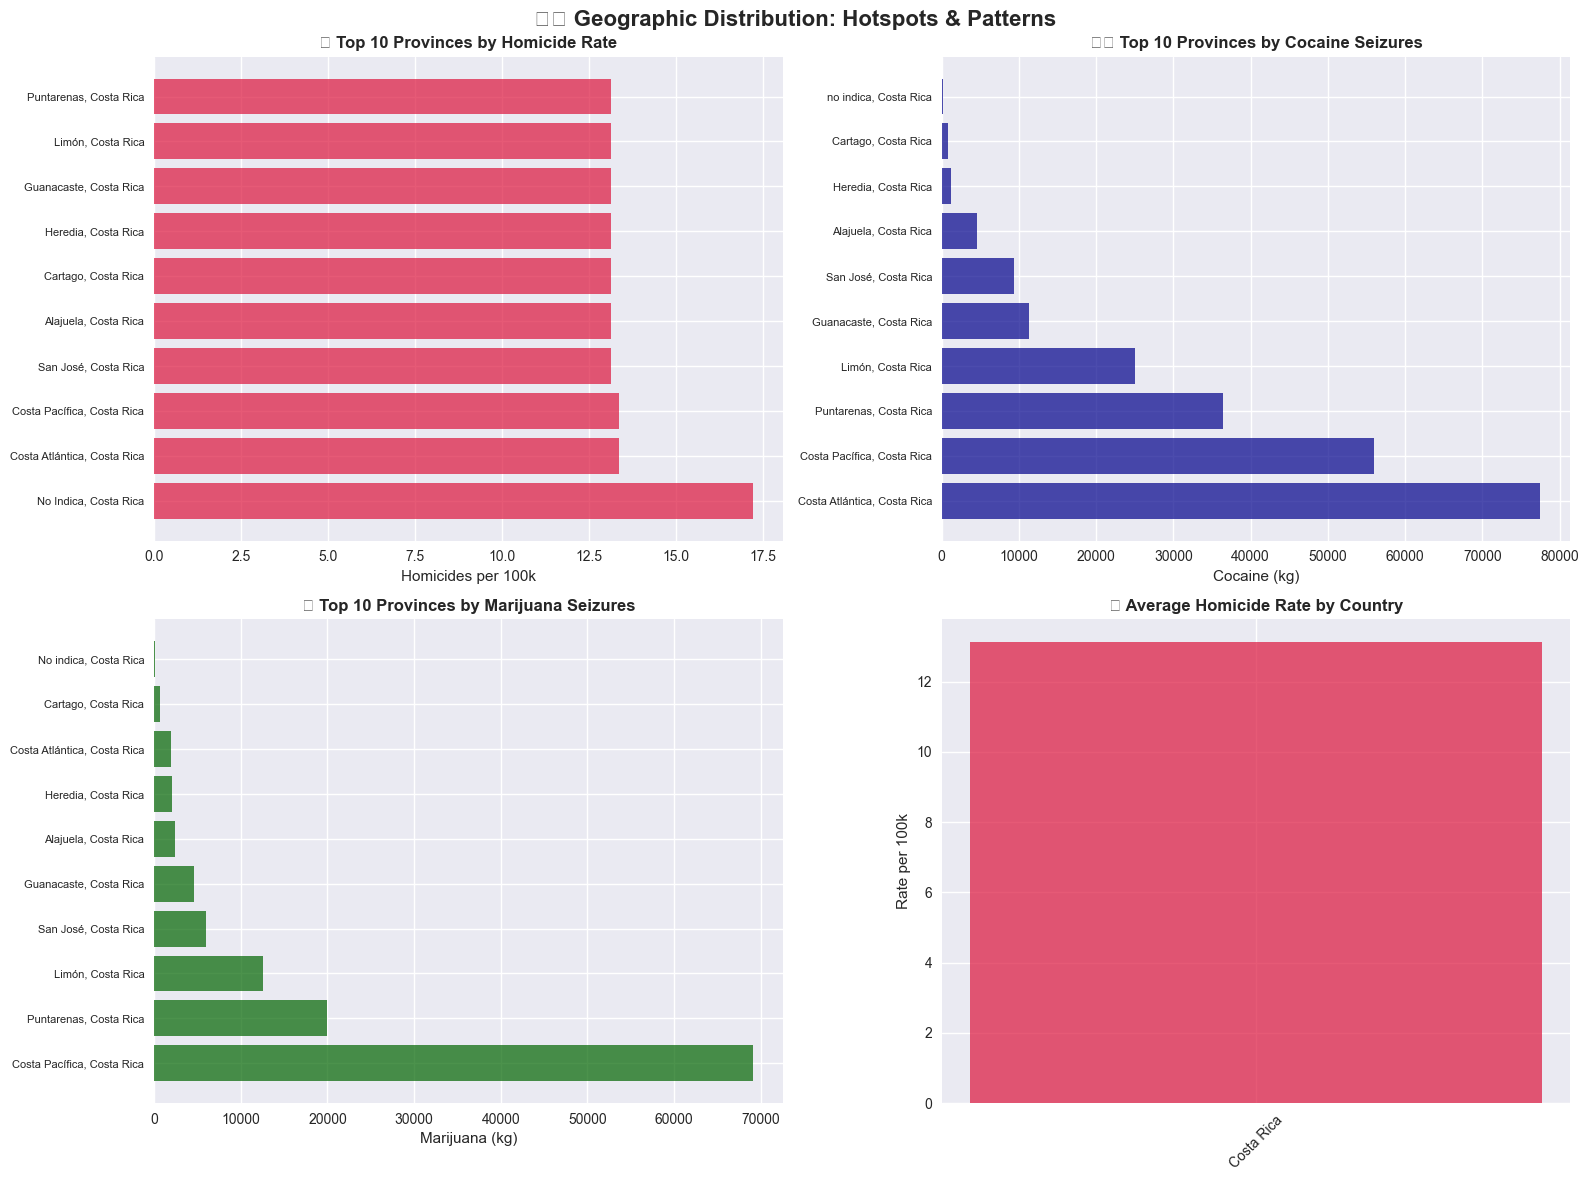


🏆 Geographic Champions (or Villains):

Highest Homicide Rates:
  1. No Indica, Costa Rica: 17.2 per 100k
  2. Costa Atlántica, Costa Rica: 13.3 per 100k
  3. Costa Pacífica, Costa Rica: 13.3 per 100k
  4. San José, Costa Rica: 13.1 per 100k
  5. Alajuela, Costa Rica: 13.1 per 100k

Largest Cocaine Seizures:
  1. Costa Atlántica, Costa Rica: 77,513 kg
  2. Costa Pacífica, Costa Rica: 55,941 kg
  3. Puntarenas, Costa Rica: 36,440 kg
  4. Limón, Costa Rica: 24,975 kg
  5. Guanacaste, Costa Rica: 11,268 kg

Largest Marijuana Seizures:
  1. Costa Pacífica, Costa Rica: 69,064 kg
  2. Puntarenas, Costa Rica: 19,994 kg
  3. Limón, Costa Rica: 12,515 kg
  4. San José, Costa Rica: 5,995 kg
  5. Guanacaste, Costa Rica: 4,549 kg

📊 Concentration Analysis:
Top 5 provinces account for 92.8% of all cocaine seizures
Top 5 provinces account for 94.0% of all marijuana seizures


In [117]:
# Geographic Analysis
print("=== GEOGRAPHIC HOTSPOTS ANALYSIS ===")

# Country-level analysis
country_analysis = merged_df.groupby('país').agg({
    'tasa_100mil_país': 'mean',
    'cocaína_(kg)': 'sum',
    'marihuana_(kg)': 'sum',
    'cocaína_eventos': 'sum',
    'marihuana_eventos': 'sum',
    'habitantes_país': 'mean'
}).round(2)

# Province-level analysis (top 10 by different metrics)
province_analysis = merged_df.groupby(['país', 'provincia']).agg({
    'tasa_100mil_país': 'mean',
    'cocaína_(kg)': 'sum',
    'marihuana_(kg)': 'sum',
    'cocaína_eventos': 'sum',
    'marihuana_eventos': 'sum'
}).reset_index()

# Create geographic visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🗺️ Geographic Distribution: Hotspots & Patterns', fontsize=16, fontweight='bold')

# Top provinces by homicide rate
top_homicide_provinces = province_analysis.nlargest(10, 'tasa_100mil_país')
axes[0,0].barh(range(len(top_homicide_provinces)), top_homicide_provinces['tasa_100mil_país'],
               color='crimson', alpha=0.7)
axes[0,0].set_yticks(range(len(top_homicide_provinces)))
axes[0,0].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_homicide_provinces.iterrows()],
                          fontsize=8)
axes[0,0].set_title('🔴 Top 10 Provinces by Homicide Rate', fontweight='bold')
axes[0,0].set_xlabel('Homicides per 100k')

# Top provinces by cocaine seizures
top_cocaine_provinces = province_analysis.nlargest(10, 'cocaína_(kg)')
axes[0,1].barh(range(len(top_cocaine_provinces)), top_cocaine_provinces['cocaína_(kg)'],
               color='darkblue', alpha=0.7)
axes[0,1].set_yticks(range(len(top_cocaine_provinces)))
axes[0,1].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_cocaine_provinces.iterrows()],
                          fontsize=8)
axes[0,1].set_title('❄️ Top 10 Provinces by Cocaine Seizures', fontweight='bold')
axes[0,1].set_xlabel('Cocaine (kg)')

# Top provinces by marijuana seizures
top_marijuana_provinces = province_analysis.nlargest(10, 'marihuana_(kg)')
axes[1,0].barh(range(len(top_marijuana_provinces)), top_marijuana_provinces['marihuana_(kg)'],
               color='darkgreen', alpha=0.7)
axes[1,0].set_yticks(range(len(top_marijuana_provinces)))
axes[1,0].set_yticklabels([f"{row['provincia']}, {row['país']}" for _, row in top_marijuana_provinces.iterrows()],
                          fontsize=8)
axes[1,0].set_title('🌿 Top 10 Provinces by Marijuana Seizures', fontweight='bold')
axes[1,0].set_xlabel('Marijuana (kg)')

# Country comparison
country_summary = merged_df.groupby('país')['tasa_100mil_país'].mean().sort_values(ascending=False)
axes[1,1].bar(range(len(country_summary)), country_summary.values,
              color=['crimson', 'darkred', 'red'], alpha=0.7)
axes[1,1].set_xticks(range(len(country_summary)))
axes[1,1].set_xticklabels(country_summary.index, rotation=45)
axes[1,1].set_title('🌍 Average Homicide Rate by Country', fontweight='bold')
axes[1,1].set_ylabel('Rate per 100k')

plt.tight_layout()
plt.show()

# Print detailed geographic insights
print("\n🏆 Geographic Champions (or Villains):")
print("\nHighest Homicide Rates:")
for i, (_, row) in enumerate(top_homicide_provinces.head(5).iterrows()):
    print(f"  {i+1}. {row['provincia']}, {row['país']}: {row['tasa_100mil_país']:.1f} per 100k")

print("\nLargest Cocaine Seizures:")
for i, (_, row) in enumerate(top_cocaine_provinces.head(5).iterrows()):
    print(f"  {i+1}. {row['provincia']}, {row['país']}: {row['cocaína_(kg)']:,.0f} kg")

print("\nLargest Marijuana Seizures:")
for i, (_, row) in enumerate(top_marijuana_provinces.head(5).iterrows()):
    print(f"  {i+1}. {row['provincia']}, {row['país']}: {row['marihuana_(kg)']:,.0f} kg")

# Calculate concentration metrics
total_cocaine = merged_df['cocaína_(kg)'].sum()
total_marijuana = merged_df['marihuana_(kg)'].sum()

print(f"\n📊 Concentration Analysis:")
print(f"Top 5 provinces account for {top_cocaine_provinces.head(5)['cocaína_(kg)'].sum()/total_cocaine*100:.1f}% of all cocaine seizures")
print(f"Top 5 provinces account for {top_marijuana_provinces.head(5)['marihuana_(kg)'].sum()/total_marijuana*100:.1f}% of all marijuana seizures")

=== CORRELATION & RELATIONSHIP ANALYSIS ===


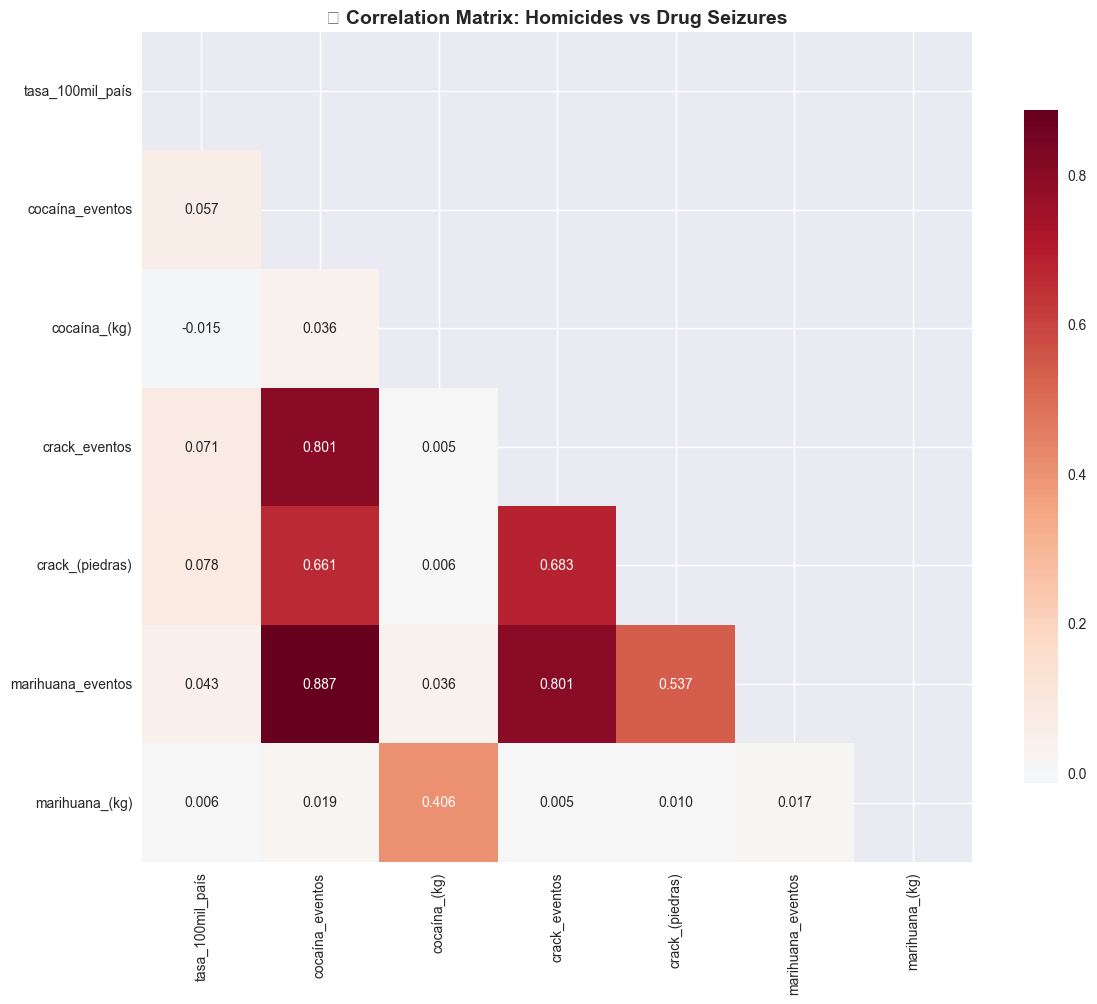


🎯 Correlations with Homicide Rate:
  crack_(piedras): 0.078 (Weak Positive)
  crack_eventos: 0.071 (Weak Positive)
  cocaína_eventos: 0.057 (Weak Positive)
  marihuana_eventos: 0.043 (Weak Positive)
  cocaína_(kg): -0.015 (Weak Negative)
  marihuana_(kg): 0.006 (Weak Positive)


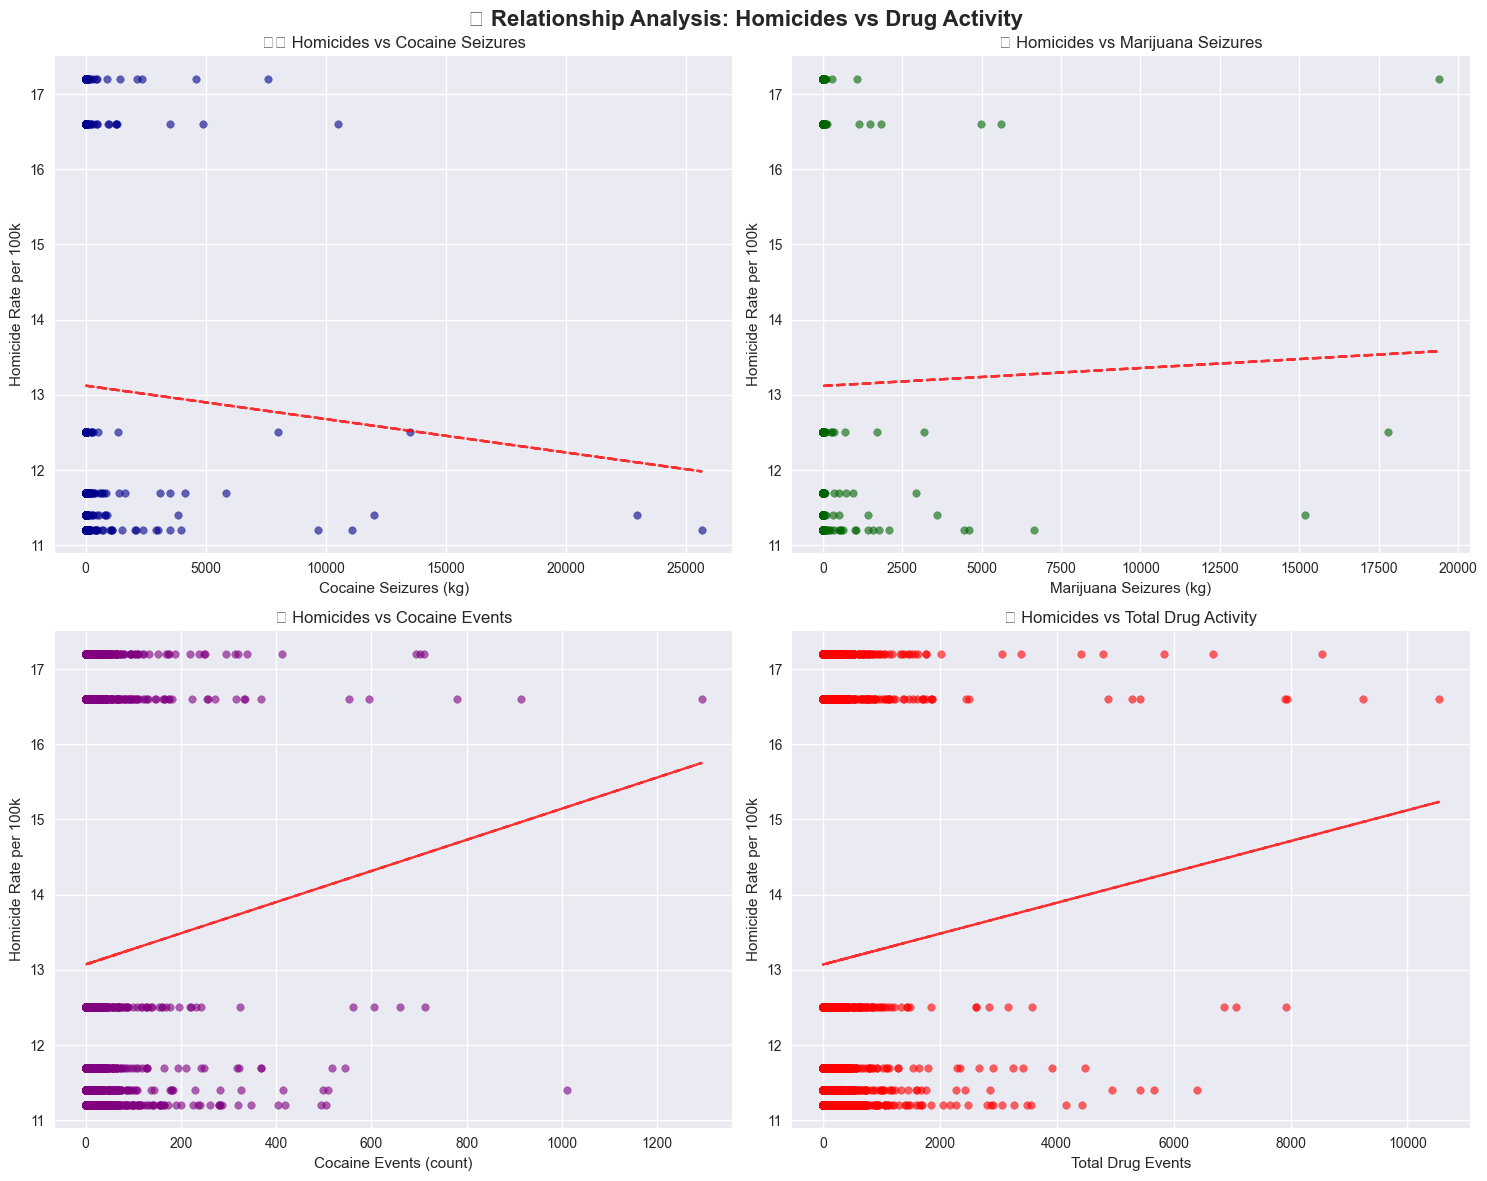


📈 Statistical Significance Tests:
  cocaína_(kg) vs Homicide Rate: r=-0.015, p=0.3931 NS
  marihuana_(kg) vs Homicide Rate: r=0.006, p=0.7431 NS
  cocaína_eventos vs Homicide Rate: r=0.057, p=0.0010 ***
  total_drug_events vs Homicide Rate: r=0.053, p=0.0019 **

💊 Drug Type Analysis:
Total seizures:
  Cocaine: 222,227 kg
  Marijuana: 119,266 kg
  Crack: 2,472,718 pieces

Total events:
  Cocaine Events: 79,354
  Marijuana Events: 587,867
  Crack Events: 145,641

⚡ Seizure Efficiency (kg per event):
  Cocaine: 2.8 kg per event
  Marijuana: 0.2 kg per event


In [118]:
# Correlation and Relationship Analysis
print("=== CORRELATION & RELATIONSHIP ANALYSIS ===")

# Select numerical columns for correlation
numerical_cols = ['tasa_100mil_país', 'cocaína_eventos', 'cocaína_(kg)', 
                  'crack_eventos', 'crack_(piedras)', 'marihuana_eventos', 'marihuana_(kg)']

# Calculate correlation matrix
correlation_matrix = merged_df[numerical_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', mask=mask, cbar_kws={'shrink': 0.8})
plt.title('🔥 Correlation Matrix: Homicides vs Drug Seizures', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Key correlations with homicide rate
homicide_correlations = correlation_matrix['tasa_100mil_país'].sort_values(key=abs, ascending=False)[1:]
print("\n🎯 Correlations with Homicide Rate:")
for var, corr in homicide_correlations.items():
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    direction = "Positive" if corr > 0 else "Negative"
    print(f"  {var}: {corr:.3f} ({strength} {direction})")

# Scatter plot analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Relationship Analysis: Homicides vs Drug Activity', fontsize=16, fontweight='bold')

# Homicides vs Cocaine seizures
axes[0,0].scatter(merged_df['cocaína_(kg)'], merged_df['tasa_100mil_país'], 
                  alpha=0.6, color='darkblue', s=30)
axes[0,0].set_xlabel('Cocaine Seizures (kg)')
axes[0,0].set_ylabel('Homicide Rate per 100k')
axes[0,0].set_title('❄️ Homicides vs Cocaine Seizures')
z = np.polyfit(merged_df['cocaína_(kg)'], merged_df['tasa_100mil_país'], 1)
p = np.poly1d(z)
axes[0,0].plot(merged_df['cocaína_(kg)'], p(merged_df['cocaína_(kg)']), "r--", alpha=0.8)

# Homicides vs Marijuana seizures
axes[0,1].scatter(merged_df['marihuana_(kg)'], merged_df['tasa_100mil_país'], 
                  alpha=0.6, color='darkgreen', s=30)
axes[0,1].set_xlabel('Marijuana Seizures (kg)')
axes[0,1].set_ylabel('Homicide Rate per 100k')
axes[0,1].set_title('🌿 Homicides vs Marijuana Seizures')
z = np.polyfit(merged_df['marihuana_(kg)'], merged_df['tasa_100mil_país'], 1)
p = np.poly1d(z)
axes[0,1].plot(merged_df['marihuana_(kg)'], p(merged_df['marihuana_(kg)']), "r--", alpha=0.8)

# Homicides vs Cocaine events
axes[1,0].scatter(merged_df['cocaína_eventos'], merged_df['tasa_100mil_país'], 
                  alpha=0.6, color='purple', s=30)
axes[1,0].set_xlabel('Cocaine Events (count)')
axes[1,0].set_ylabel('Homicide Rate per 100k')
axes[1,0].set_title('🔵 Homicides vs Cocaine Events')
z = np.polyfit(merged_df['cocaína_eventos'], merged_df['tasa_100mil_país'], 1)
p = np.poly1d(z)
axes[1,0].plot(merged_df['cocaína_eventos'], p(merged_df['cocaína_eventos']), "r--", alpha=0.8)

# Homicides vs Total drug activity
merged_df['total_drug_events'] = (merged_df['cocaína_eventos'] + 
                                 merged_df['marihuana_eventos'] + 
                                 merged_df['crack_eventos'])
axes[1,1].scatter(merged_df['total_drug_events'], merged_df['tasa_100mil_país'], 
                  alpha=0.6, color='red', s=30)
axes[1,1].set_xlabel('Total Drug Events')
axes[1,1].set_ylabel('Homicide Rate per 100k')
axes[1,1].set_title('🔴 Homicides vs Total Drug Activity')
z = np.polyfit(merged_df['total_drug_events'], merged_df['tasa_100mil_país'], 1)
p = np.poly1d(z)
axes[1,1].plot(merged_df['total_drug_events'], p(merged_df['total_drug_events']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Statistical significance tests
print("\n📈 Statistical Significance Tests:")
for var in ['cocaína_(kg)', 'marihuana_(kg)', 'cocaína_eventos', 'total_drug_events']:
    correlation, p_value = stats.pearsonr(merged_df[var], merged_df['tasa_100mil_país'])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "NS"
    print(f"  {var} vs Homicide Rate: r={correlation:.3f}, p={p_value:.4f} {significance}")

# Drug type comparison
print("\n💊 Drug Type Analysis:")
drug_totals = {
    'Cocaine': merged_df['cocaína_(kg)'].sum(),
    'Marijuana': merged_df['marihuana_(kg)'].sum(),
    'Crack': merged_df['crack_(piedras)'].sum()
}

event_totals = {
    'Cocaine Events': merged_df['cocaína_eventos'].sum(),
    'Marijuana Events': merged_df['marihuana_eventos'].sum(),
    'Crack Events': merged_df['crack_eventos'].sum()
}

print("Total seizures:")
for drug, amount in drug_totals.items():
    if 'Crack' in drug:
        print(f"  {drug}: {amount:,.0f} pieces")
    else:
        print(f"  {drug}: {amount:,.0f} kg")

print("\nTotal events:")
for event, count in event_totals.items():
    print(f"  {event}: {count:,.0f}")

# Calculate efficiency metrics
print("\n⚡ Seizure Efficiency (kg per event):")
cocaine_efficiency = merged_df['cocaína_(kg)'].sum() / merged_df['cocaína_eventos'].sum()
marijuana_efficiency = merged_df['marihuana_(kg)'].sum() / merged_df['marihuana_eventos'].sum()
print(f"  Cocaine: {cocaine_efficiency:.1f} kg per event")
print(f"  Marijuana: {marijuana_efficiency:.1f} kg per event")